# Conformal prediction for Regressors

### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from math import ceil
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

### Train and test datasets

In [2]:
housing = fetch_california_housing(data_home='data/california_housing')
print(f"Shapes: {housing.data.shape}, {housing.target.shape}")
print("Feature names:", housing.feature_names)
print("Target names:", housing.target_names)

Shapes: (20640, 8), (20640,)
Feature names: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Target names: ['MedHouseVal']


In [3]:
# Treure random_state

In [4]:
X_train, X_test, y_train, y_test = train_test_split(housing.data, housing.target, test_size=0.2, random_state=0)

## Gradient Boosting Regressor

### Hyperparameters and loss function

In [5]:
learning_rate = 0.1
n_estimators = 200

In [6]:
loss = 'quantile'

In [7]:
alpha = 0.1
lq = alpha/2
uq = 1-lq
print(f"Lower quantile: {lq}, upper quantile: {uq}, coverage: {1-alpha}")

Lower quantile: 0.05, upper quantile: 0.95, coverage: 0.9


### Training

In [8]:
gbr_lq = GradientBoostingRegressor(loss=loss, learning_rate=learning_rate, n_estimators=n_estimators, alpha=lq)
gbr_uq = GradientBoostingRegressor(loss=loss, learning_rate=learning_rate, n_estimators=n_estimators, alpha=uq)
gbr = GradientBoostingRegressor(learning_rate=learning_rate, n_estimators=n_estimators)

gbr_lq.fit(X_train, y_train)
gbr_uq.fit(X_train, y_train)
gbr.fit(X_train, y_train)

print("Done")

Done


### Predictions

In [9]:
y_lower = gbr_lq.predict(X_test)
y_upper = gbr_uq.predict(X_test)
y_pred = gbr.predict(X_test)

**No hi ha manera de visualitzar-ho bé**

In [10]:
#fig = plt.figure(figsize=(10, 10))
#plt.plot(X_test, y_test, "b.", markersize=10, label="Test observations")
#plt.plot(X_test, y_upper, "k-")
#plt.plot(X_test, y_lower, "k-")
#plt.fill_between(
#    X_test.ravel(), y_lower, y_upper, alpha=0.4, label="Predicted 90% interval"
#)
#plt.xlabel("$x$")
#plt.ylabel("$f(x)$")
#plt.ylim(-10, 25)
#plt.legend(loc="upper left")
#plt.show()

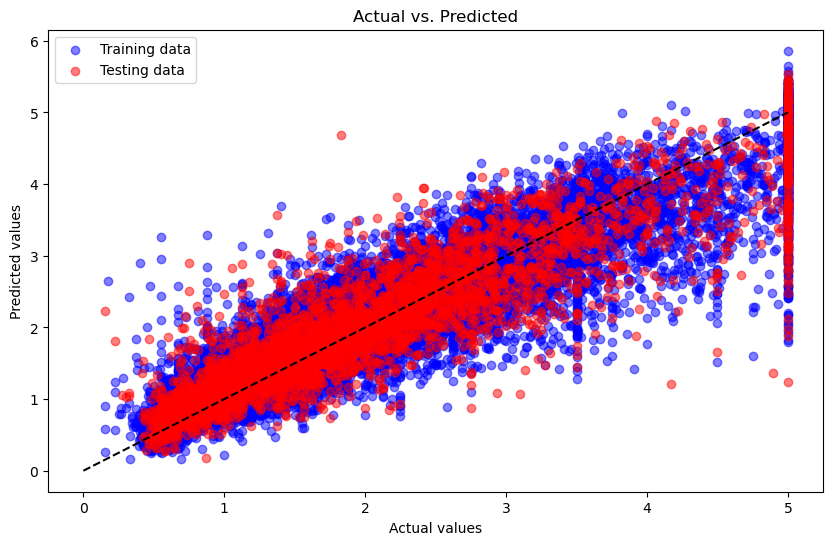

In [11]:
# Scatter plot for training data
plt.figure(figsize=(10, 6))
plt.scatter(y_train, gbr.predict(X_train), color='blue', alpha=0.5, label='Training data')
# Scatter plot for testing data
plt.scatter(y_test, gbr.predict(X_test), color='red', alpha=0.5, label='Testing data')

# Plotting the perfect fit line
maX_test = max(y_train.max(), y_test.max())
plt.plot([0, maX_test], [0, maX_test], color='black', linestyle='--')

plt.title('Actual vs. Predicted')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.legend(loc='upper left')
plt.show()


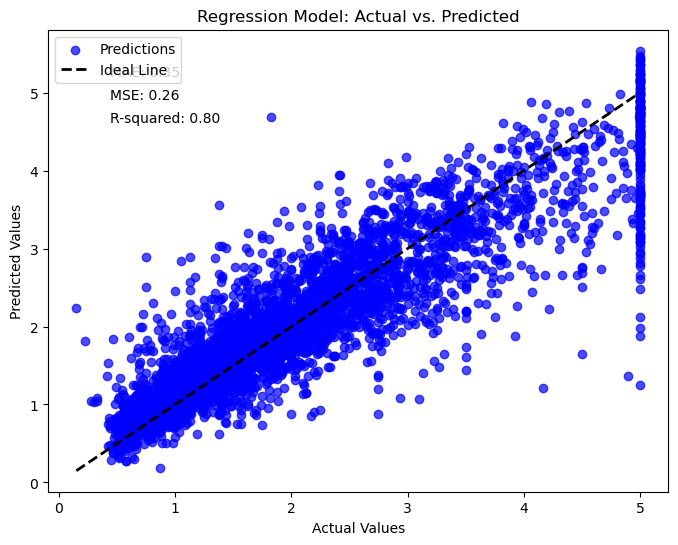

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Assuming you have y_test (actual values) and y_pred (predicted values)
# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='b', label='Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2, label='Ideal Line')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Regression Model: Actual vs. Predicted')
plt.legend()

# Display evaluation metrics
plt.text(0.1, 0.9, f'MAE: {mae:.2f}', transform=plt.gca().transAxes)
plt.text(0.1, 0.85, f'MSE: {mse:.2f}', transform=plt.gca().transAxes)
plt.text(0.1, 0.8, f'R-squared: {r2:.2f}', transform=plt.gca().transAxes)

plt.show()

## Conformal prediction and uncertainty quantification

In [13]:
len(X_test)

4128

In [14]:
num_samples = 100

In [15]:
X_calib, y_calib = X_test[:num_samples], y_test[:num_samples]

In [16]:
y_lq = gbr_lq.predict(X_calib)
y_uq = gbr_uq.predict(X_calib)
y_fill = list(zip(y_lq, y_uq))

In [17]:
scores = [max(l_pred-y, y-u_pred) for (l_pred, u_pred), y in zip(y_fill, y_calib)]

In [18]:
p = 1-alpha
print(p)

0.9


In [19]:
p_hat = ceil((num_samples+1)*p) / num_samples
print(p_hat)

0.91


In [20]:
q_hat = np.quantile(scores, p_hat, method='higher')
print(q_hat)

0.09446415789901019


### Getting prediction sets

In [21]:
X_remain, y_remain = X_test[num_samples:], y_test[num_samples:]

In [22]:
gbr_lq.predict(X_remain) - 1

array([ 0.19248365,  0.23551057,  0.16314111, ..., -0.08969589,
        0.99730288,  0.27948327])

In [23]:
y_lq = gbr_lq.predict(X_remain) - q_hat
y_uq = gbr_uq.predict(X_remain) + q_hat
y_fill = list(zip(y_lq, y_uq))

In [24]:
y_fill

[(1.0980194942092503, 2.6129318315899637),
 (1.1410464105007319, 3.0966833040099826),
 (1.0686769525513382, 2.4426504255434853),
 (1.6628036342927839, 4.600147697757308),
 (1.446248923653544, 3.093352163766275),
 (1.8080612441402328, 3.353251683776788),
 (1.028379110483828, 2.938241181232174),
 (0.49575722118647125, 2.145932557943291),
 (0.5473962689175605, 1.4768828700358099),
 (0.9861340716228773, 2.911418051364114),
 (1.6304096456299586, 3.5596044000927605),
 (0.36772398539430795, 2.416209126985736),
 (1.2365662988089676, 3.2881843633371792),
 (1.9454043551124465, 5.200183331677676),
 (1.114063792775993, 2.3651316580237984),
 (2.031347558840108, 4.7791612860709805),
 (0.9280257143863575, 1.642265143458529),
 (1.250241537534896, 2.9946807922594805),
 (0.9776972882871906, 2.6040071806556737),
 (0.7557122124780333, 2.2593566313335316),
 (1.8945413258858226, 3.5676216269843786),
 (0.7327033033651345, 3.1545330440433483),
 (1.1807289521882653, 3.7613164958023413),
 (1.1217918745318323, 4